In [24]:
### Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load the Dataset

In [8]:
### Load dataset
df = pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
### check the shape
df.shape

(568454, 10)

## Data Summary

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [13]:
df.Score.value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

## EDA

In [14]:
### check for null values
df.isnull().sum()   

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

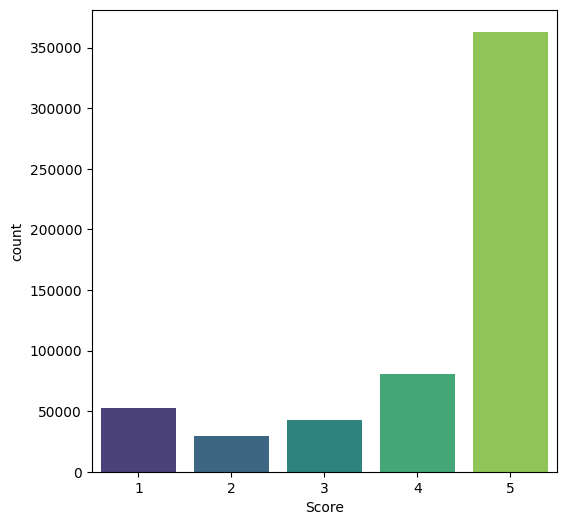

In [18]:
### Score distribution
plt.figure(figsize=(6,6))
sns.countplot(data = df, x='Score', palette = 'viridis')
plt.show()

## Data Preprocessing

In [21]:
df.Text[1:10]

1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object

In [37]:
# Since the classes are imbalanced, we'll take reviews with scores 1 and 2 as negative, 
# scores 3 and 4 as neutral and scores 5 as positive.
def categorize_score(score):
    if score in [1,2]:
        return 'Negative'
    elif score in [3,4]:
        return 'Neutral'
    else:
        return 'Positive'

In [38]:
df['Score_cat'] = df['Score'].apply(categorize_score)

In [43]:
df['Score_cat'].value_counts()

Score_cat
Positive    363122
Neutral     123295
Negative     82037
Name: count, dtype: int64

In [44]:
# Take a sample of 10000 reviews from every category
df_pos = df[df['Score_cat']=='Positive'].sample(10000, random_state=22)
df_neu = df[df['Score_cat']=='Neutral'].sample(10000, random_state=22)
df_neg = df[df['Score_cat']=='Negative'].sample(10000, random_state=22)
df_final = pd.concat([df_pos, df_neu, df_neg], ignore_index=True)
print(df_final.shape)
df_final.Score_cat.value_counts()

(30000, 11)


Score_cat
Positive    10000
Neutral     10000
Negative    10000
Name: count, dtype: int64

In [ ]:
# def preprocess_text(text):
#     ## Convert to lowercase
#     text = text.lower()

#     ## Remove punctuation
#     text = ''.join(char for char in text if char.isalnum() or char.isspace())

#     ## Tokenization
#     tokens = text.split()

#     ## Remove stopwords
#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in tokens if word not in stop_words]
#     ## Lemmatization
#     lemmatizer = WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(word) for word in tokens]

#     ## Join tokens back to string
#     return ' '.join(tokens)


In [ ]:
# Using Spacy to preprocess text

nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    ## Convert to lowercase
    text = text.lower()

    doc = nlp(text)
    processed_text = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            processed_text.append(token.lemma_)
    
    return ' '.join(processed_text)

    

In [108]:
text = 'hi'
doc = nlp(text)
doc.vector

array([-1.32331938e-01, -1.20258594e+00,  5.68472981e-01,  4.08427238e-01,
       -1.08017707e+00,  1.86950177e-01,  6.65968359e-01,  9.98785019e-01,
       -1.09002757e+00, -1.18380994e-01, -2.00596243e-01, -1.42729774e-01,
        6.64104372e-02, -1.24845877e-01, -1.11187923e+00,  1.09497130e-01,
       -5.28793335e-02, -1.24980474e+00, -6.76295638e-01,  4.69459176e-01,
       -1.04521275e+00,  4.72685277e-01, -6.02380037e-01,  1.10388339e-01,
        8.05376291e-01, -5.13097107e-01,  1.27543092e+00,  1.00785744e+00,
       -1.84762144e+00,  5.36007345e-01,  1.74150765e-01,  3.59169543e-01,
        4.36849892e-01,  1.62444878e+00,  1.51347220e-01, -5.29605269e-01,
       -1.89286113e-01,  1.33114010e-01,  8.88527334e-02, -2.87222601e-02,
       -6.74080729e-01, -2.01747552e-01,  9.30199146e-01, -4.47787642e-02,
       -6.69162154e-01,  7.99472034e-01, -3.13535839e-01, -8.13493431e-01,
        3.67560714e-01, -9.32136297e-01,  1.17919910e+00,  3.58275533e-01,
       -1.12605596e+00,  

In [45]:
df_final['processed_text'] = df_final['Text'].apply(preprocess_text)
df_final[['Text', 'processed_text']].head()

,Text,processed_text
0,"Thank You. I am very pleased. Quality cat food. Good for male cats, high water content.<br />Some other brands on Amazon are made abroad then distributed by US. company. The b.f.f product reads<br />made in Massachusetts. Glad there is Taurine in it. First ingredient tuna, then water for processing,also included: Potato Starch. The Potato Starch may not be for all cats. I am not vetrinarian. I have always fed my cat dry and wet from Premium companies. This was my first time finding a brand for him on amazon. For the price and convenience, I am ordering again... but mostly because my cat loves it. Thank You.",thank pleased quality cat food good male cat high water content.<br />some brand amazon abroad distribute company b.f.f product read < br />made massachusetts glad taurine ingredient tuna water processing include potato starch potato starch cat vetrinarian feed cat dry wet premium company time find brand amazon price convenience order cat love thank
1,"My mom used sugar twin to make iced tea and I do the same for my own family. Suddenly, it is impossible to find in any store in my area. I was very worried, as I have tried other products and nothing tastes like Sugar Twin. I am so glad to see that I can order it online. To the manufacturer: Please don't stop making this product!!",mom sugar twin iced tea family suddenly impossible find store area worried try product taste like sugar twin glad order online manufacturer stop make product
2,"Because a kind soul brought her Keurig into work, I got to try Timothy's Columbian decaf. The coffee doesn't have any of the after taste associated with decaf. It just tastes like a smooth cup of coffee. After my colleague took her machine home, I craved another cup of that coffee. So, I bought a Keurig and began searching for the best price I could get on Timothy's Columbian Decaf. Thank you Amazon for making this 50 pack offer. The deal is even better if you ""subscribe and save.""",kind soul bring keurig work get try timothy columbian decaf coffee taste associate decaf taste like smooth cup coffee colleague take machine home crave cup coffee buy keurig begin search good price timothy columbian decaf thank amazon make 50 pack offer deal well subscribe save
3,"I have tried Herrs, UTZ, wise, pringles, lays etc....but Kettle tasted the best. The quantity of salt used is the optimum which is required.<br /><br />Although they say serving size 1 ounce, you will finish the whole packet in no time. Total calories is 300 for 2 ounce bag. This is slightly on the higher side. But still it is ok, as they have not compromised on the taste.<br /><br />Only issue was that all packets have some burnt chips, which taste bad. Kettle should take care when packing to ensure no burnt chips are there.<br /><br />Thanks to Amazon to get 24 bags for just 12 bucks with free shipping using their coupon.",try herrs utz wise pringle lay etc kettle taste good quantity salt optimum required.<br /><br />although serve size 1 ounce finish packet time total calorie 300 2 ounce bag slightly high ok compromise taste.<br /><br />only issue packet burn chip taste bad kettle care pack ensure burn chip there.<br /><br />thanks amazon 24 bag 12 buck free shipping coupon
4,"I've now ordered this pumpkin pesto several times, so let me assure you it's a winner. The wonderful flavor of pumpkins with the sweetness of sweet potatoes or maybe butternut squash, either way it's very tasty. Just remember this is pesto and all pesto's are a concentrated flavor, so cut with say mascrapone cheese if you were going to use this for a filling of ravoli or just a small amount with your pasta dish.",order pumpkin pesto time let assure winner wonderful flavor pumpkin sweetness sweet potato maybe butternut squash way tasty remember pesto pesto concentrated flavor cut mascrapone cheese go use filling ravoli small pasta dish


## 1. Using Tf-Idf Vectorizer with Naive Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
tf_idf = TfidfVectorizer()

# Fit and transform the processed text
tf_idf_matrix = tf_idf.fit_transform(df_final['processed_text'])

In [52]:
tf_idf_matrix.shape

(30000, 28427)

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, df_final['Score_cat'], test_size = 0.2, random_state = 22)

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24000, 28427), (6000, 28427), (24000,), (6000,))

In [73]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)
y_train


array([0, 2, 1, ..., 0, 0, 1], shape=(24000,))

### 1.1 Training the Model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Create a multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Fit the classifier on the training data
model = nb_classifier.fit(X_train, y_train)


In [75]:
model

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


### 1.2 Evaluation

In [ ]:
# Predicting on the test set
y_pred = nb_classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.6456666666666667

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.69      0.72      2015
           1       0.53      0.62      0.57      1996
           2       0.69      0.62      0.65      1989

    accuracy                           0.65      6000
   macro avg       0.65      0.65      0.65      6000
weighted avg       0.66      0.65      0.65      6000



In [84]:
from sklearn.metrics import ConfusionMatrixDisplay
print(confusion_matrix(y_test, y_pred))

[[1400  494  121]
 [ 327 1237  432]
 [ 163  589 1237]]


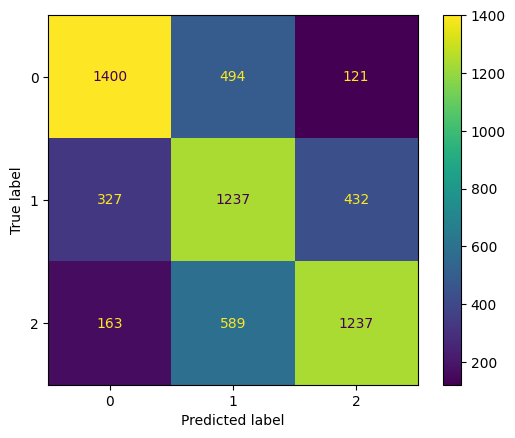

In [91]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels = le.classes_)
disp.plot()

## 2. Using Tf-Idf Vectorizer with SVM

In [95]:
from sklearn.svm import SVC

svc = SVC(kernel = 'rbf')

## Fit the SVM model
model_svm = svc.fit(X_train, y_train)

In [96]:
model_svm

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [97]:
# Predicting on the test set
y_pred_svm = svc.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_svm)}')

Accuracy: 0.6956666666666667


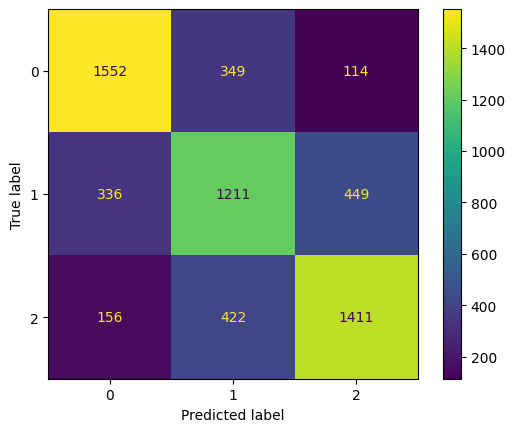

In [99]:
# Display Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm_svm, display_labels = le.classes_).plot()